In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf
import keras
from omnifold.net import weighted_binary_crossentropy
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
# Register OmniFold custom loss so Keras 3 can clone models
keras.saving.register_keras_serializable(package="omnifold")(weighted_binary_crossentropy)
import os

gpu_number="7"
os.environ['CUDA_VISIBLE_DEVICES']=gpu_number # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']=gpu_number
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)


2025-12-05 14:57:00.960440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 14:57:00.981270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764943020.999717 3798898 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764943021.005199 3798898 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764943021.021828 3798898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from omnifold import DataLoader, MultiFold, PET, SetStyle, HistRoutine, MLP

# OmniFold example using high-level features as inputs

In [3]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

In [4]:
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
import PET
from my_utils import *
pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset)

In [5]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

herwig_loader = DataLoader(reco = X_herwig_reco_scaled[:,5,0], gen = X_herwig_truth_scaled[:,5,0], weight = herwig_subset['eventWeight'],
                           pass_reco = herwig_subset['pass_reco'], pass_gen = herwig_subset['pass_particle'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled[:,5,0], gen = X_pythia_truth_scaled[:,5,0], weight = pythia_train['eventWeight'],
                           pass_reco = pythia_train['pass_reco'], pass_gen = pythia_train['pass_particle'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test[:,5,0], gen = pythia_truth_test[:,5,0], weight = pythia_test['eventWeight'],
                           pass_reco = pythia_test['pass_reco'], pass_gen = pythia_test['pass_particle'], normalize=False)

In [6]:
herwig_loader.gen.shape

(1000000,)

## Let's take a quick look at the data

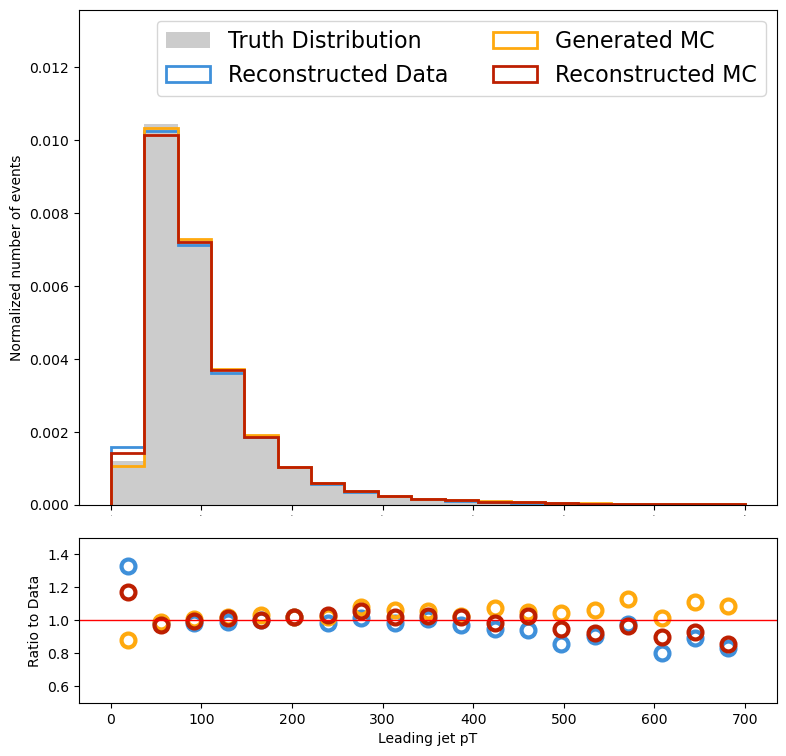

In [7]:
data_dict = {
    'Truth Distribution': herwig_truth[:,5,0]*herwig_subset['pass_particle'],
    'Reconstructed Data': herwig_reco[:,5,0]*herwig_subset['pass_reco'],
    'Generated MC': pythia_truth_test[:,5,0]*pythia_test['pass_particle'],
    'Reconstructed MC': pythia_reco_test[:,5,0]*pythia_test['pass_reco'],
}

weight_dict = {
    'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
    'Reconstructed Data': herwig_subset['eventWeight']*herwig_subset['pass_reco'],
    'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
    'Reconstructed MC': pythia_test['eventWeight']*pythia_test['pass_reco'],
    }

fig,_ = HistRoutine(data_dict,'Leading jet pT',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(0,700,20)
                    )

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
model1 = MLP(1)
model2 = MLP(1)

I0000 00:00:1764943116.461260 3798898 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 133844 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:e3:00.0, compute capability: 9.0


In [9]:
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

None


## Let's now unfold!

In [10]:
omnifold = MultiFold(
    "pT_test",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 512,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
    lr = 5e-5,
)

3906 training steps at reco and 3906 steps at gen


In [11]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1999872, Test events used: 399974
################################################################################
Epoch 1/100


I0000 00:00:1764943177.197434 3799872 service.cc:152] XLA service 0x7ee484004c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764943177.197474 3799872 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-12-05 14:59:37.223391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764943177.408259 3799872 cuda_dnn.cc:529] Loaded cuDNN version 90501


  59/3124 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.8105   

I0000 00:00:1764943178.036600 3799872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3124/3124 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.8273 - val_loss: 2.8154 - learning_rate: 5.0000e-05
Epoch 2/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8242 - val_loss: 2.8160 - learning_rate: 5.0000e-05
Epoch 3/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8176 - val_loss: 2.8157 - learning_rate: 5.0000e-05
Epoch 4/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8278 - val_loss: 2.8153 - learning_rate: 5.0000e-05
Epoch 5/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8185 - val_loss: 2.8158 - learning_rate: 5.0000e-05
Epoch 6/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8231 - val_loss: 2.8156 - learning_rate: 5.0000e-05
Epoch 7/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8246 - val_loss: 2.8154 - learning_rate: 5.0000e-05
Epoch 8/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.8195 - val_loss: 2.8154 - learning_rate: 5.0000e-05
Epoch 9/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.8251 - va

## Now, let's evaluate the model!

In [12]:
unfolded_weights  = omnifold.reweight(testset_loader.gen,omnifold.model2,batch_size=1000)   

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


/u/mjosef/.local/lib/python3.12/site-packages/omnifold/omnifold.py:415: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f)  # this is the crux of the reweight, approximates likelihood ratio


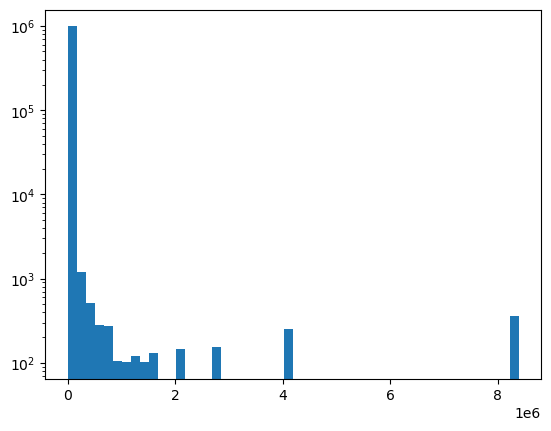

In [13]:
plt.hist(unfolded_weights, bins=50)
plt.yscale('log')
plt.show()

## More plots!

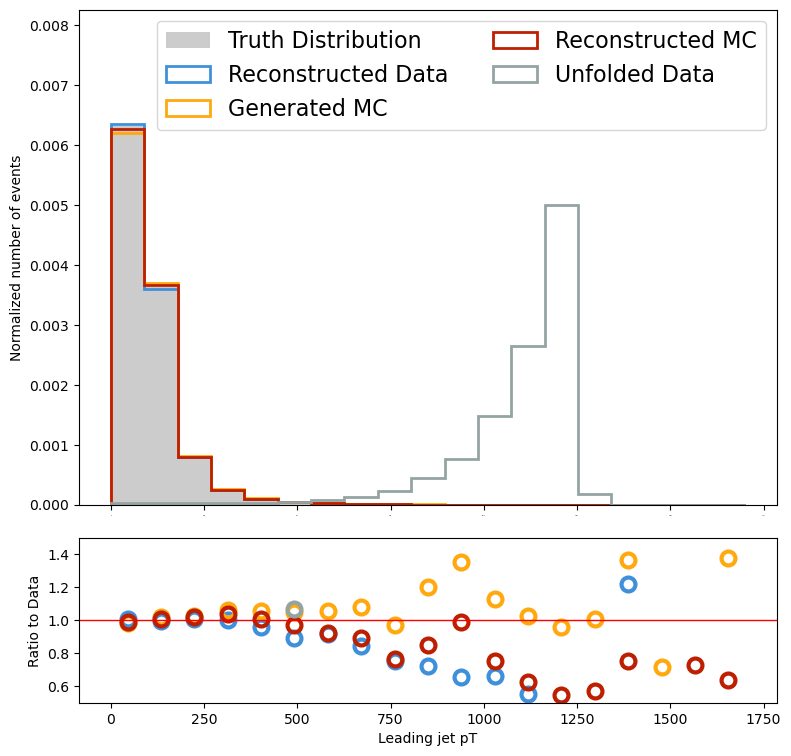

In [ ]:
data_dict = {
    'Truth Distribution': herwig_truth[:,5,0]*herwig_subset['pass_particle'],
    'Reconstructed Data': herwig_reco[:,5,0]*herwig_subset['pass_reco'],
    'Generated MC': pythia_truth_test[:,5,0]*pythia_test['pass_particle'],
    'Reconstructed MC': pythia_reco_test[:,5,0]*pythia_test['pass_reco'],
    'Unfolded Data': pythia_truth_test[:,5,0]*pythia_test['pass_particle'],
}

weight_dict = {
    'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
    'Reconstructed Data': herwig_subset['eventWeight']*herwig_subset['pass_reco'],
    'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
    'Reconstructed MC': pythia_test['eventWeight']*pythia_test['pass_reco'],
    'Unfolded Data': unfolded_weights*pythia_test['eventWeight']*pythia_test['pass_particle'],
    }

fig,_ = HistRoutine(data_dict,'Leading jet pT',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(0,700,20)
                    )
